# Metropolis-adjusted Langevin algorithm (MALA)

In this notebook we consider the sampling of a 2-D probability density using MALA.

# 0. Import packages and set some parameters

In [41]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "serif"
plt.rcParams.update({'font.size': 30})

# 1. Probability density

We first define the probability density that we wish to sample. This can of course be adapted to make the problem simpler or more complicated.

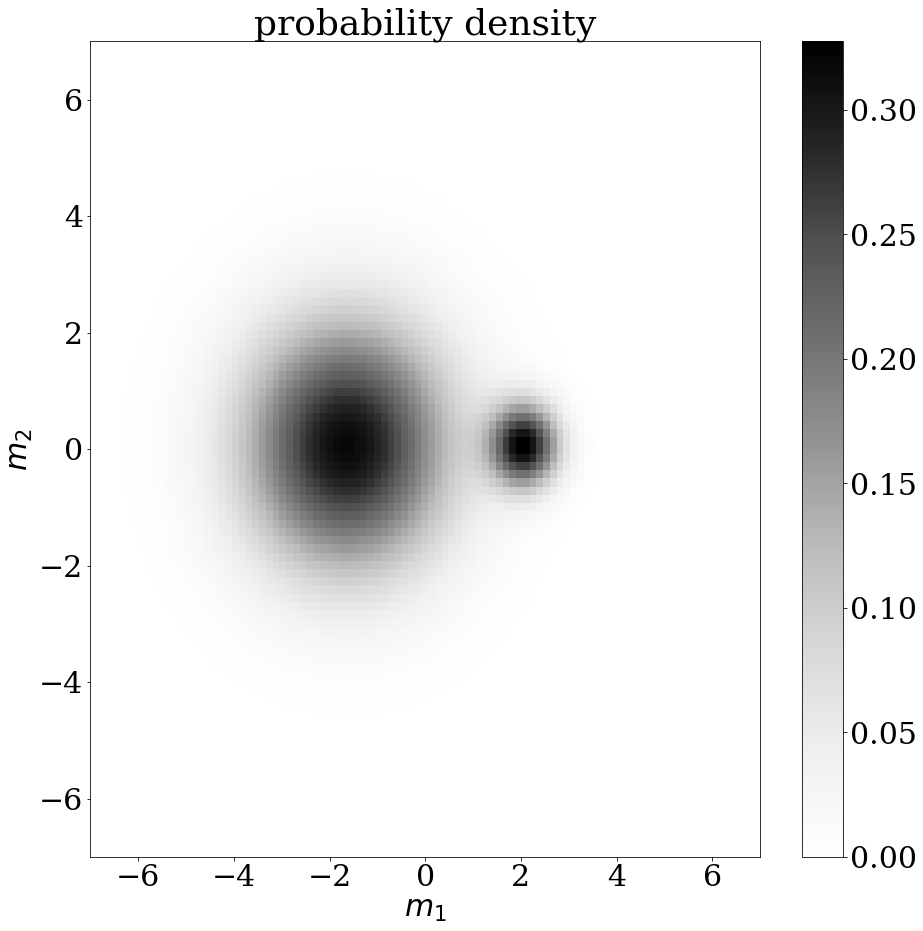

In [42]:
s1=1.5
s2=0.5
x1=-1.7
y1=0.0
x2=2.0
y2=0.0

# Define probability density as superposition of two (unnormalised) normal distributions.
def p1(x,y):
    return np.exp(-0.5*((x-x1)**2+(y-y1)**2)/s1**2)/(2.0*np.pi*s2)

def p2(x,y):
    return np.exp(-0.5*((x-x2)**2+(y-y1)**2)/s2**2)/(2.0*np.pi*s2)

def p(x,y):
    return p1(x,y)+p2(x,y)

# x- and y-derivatives of the logarithmic probability density.
def dxp(x,y):
    return ((x1-x)*p1(x,y)/s1**2 + (x2-x)*p2(x,y)/s2**2) / (p1(x,y)+p2(x,y))

def dyp(x,y):
    return ((y1-y)*p1(x,y)/s1**2 + (y2-y)*p2(x,y)/s2**2) / (p1(x,y)+p2(x,y))


# Plot.
x=np.linspace(-7.0,7.0,100)
y=np.linspace(-7.0,7.0,100)
x,y=np.meshgrid(x,y)

plt.figure(figsize=(15,15))
plt.pcolor(x,y,p(x,y),cmap='Greys')
plt.colorbar()
plt.xlabel(r'$m_1$')
plt.ylabel(r'$m_2$')
plt.title('probability density')
plt.show()

# 2. Transition probability density

To evaluate the Metropolis rule, we need an explicit expression of the transition probablity density, which we will code in a function below.

In [43]:
def T(xi,yi,xj,yj):
    x = xi - xj - 0.5 * sigma**2 * dxp(xj,yj)
    y = yi - yj - 0.5 * sigma**2 * dyp(xj,yj)
    r = x**2 + y**2
    return np.exp(-0.5*r/sigma**2)

# 3. Input parameters

Here we set the most important input parameters. They include the proposal (or search) radius, the total number of samples, and the number of samples used later for plotting.

In [50]:
# Proposal radius.
sigma=0.25

# Number of Metropolis-Hastings samples.
N=1000

# Number of samples for plotting.
N_plot=1000

# 4. Sampling

Sampling starts by the generation of a random starting point. We then randomly produce new samples - either by local or global proposals - and subject them to the Metropolis rule. The result is a vector containing all the samples.

In [63]:
# Initialise sample vectors and number of accepted models.
sx=np.zeros(N)
sy=np.zeros(N)
accept=0

# Initial values (randomly or deterministically chosen).
#sx[0],sy[0]=5.0*(np.random.rand(2)-0.5)
sx[0]=-5.0
sy[0]=5.0

# Start sampling.
for it in range(1,N):
    
    # Make a new proposal.
    sx_prop = sx[it-1] + 0.5 * sigma**2 * dxp(sx[it-1],sy[it-1]) + sigma * np.random.randn()
    sy_prop = sy[it-1] + 0.5 * sigma**2 * dyp(sx[it-1],sy[it-1]) + sigma * np.random.randn()
            
    # Compute Metropolis ratio.
    p_prop=p(sx_prop,sy_prop)*T(sx[it-1],sy[it-1],sx_prop,sy_prop)
    p_current=p(sx[it-1],sy[it-1])*T(sx_prop,sy_prop,sx[it-1],sy[it-1])
    m=p_prop/p_current
    
    # Evaluate Metropolis rule
    if m>np.random.rand():
        sx[it]=sx_prop
        sy[it]=sy_prop
        p_current=p_prop
        accept+=1
    else:
        sx[it]=sx[it-1]
        sy[it]=sy[it-1]

# 5. Output and analysis

Following the sampling, we plot the results and perform some analyses.

acceptance ratio: 0.992000 


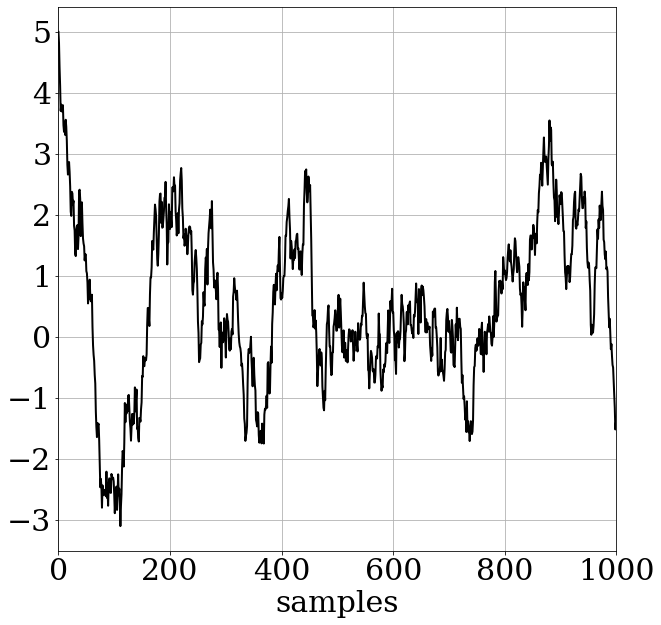

effective sample size: 12.294789


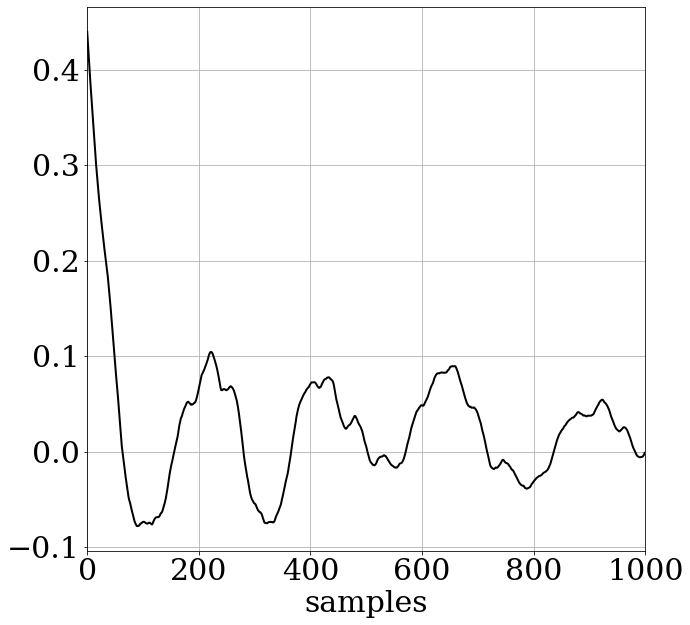

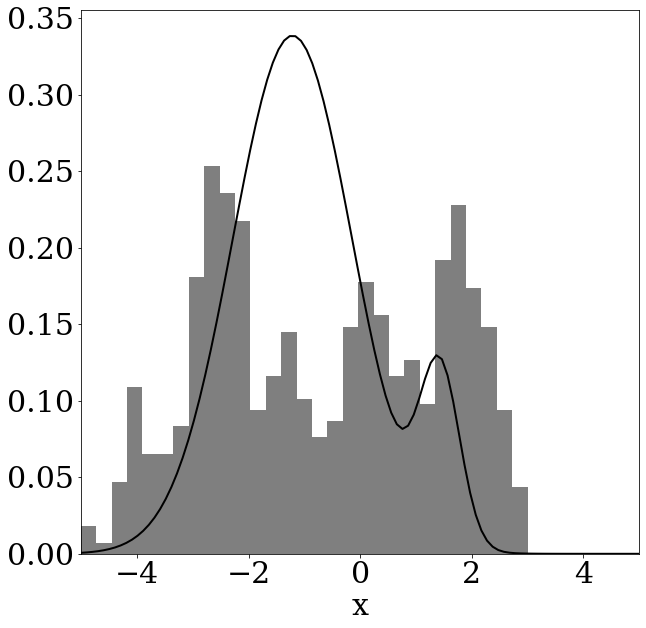

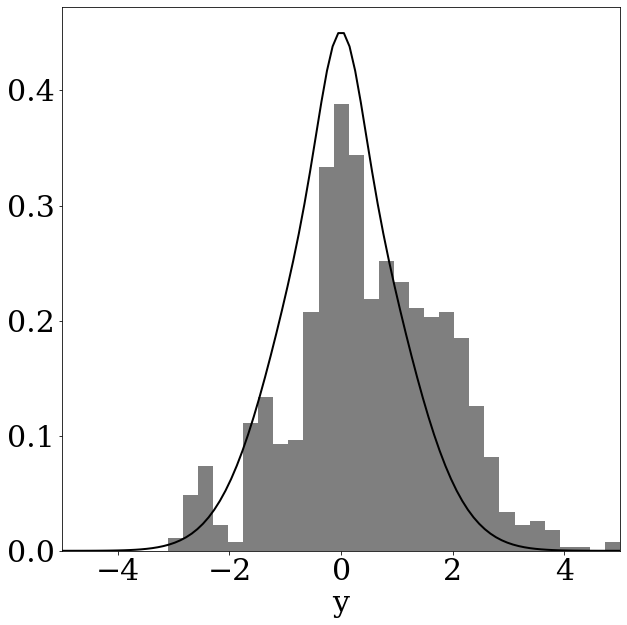

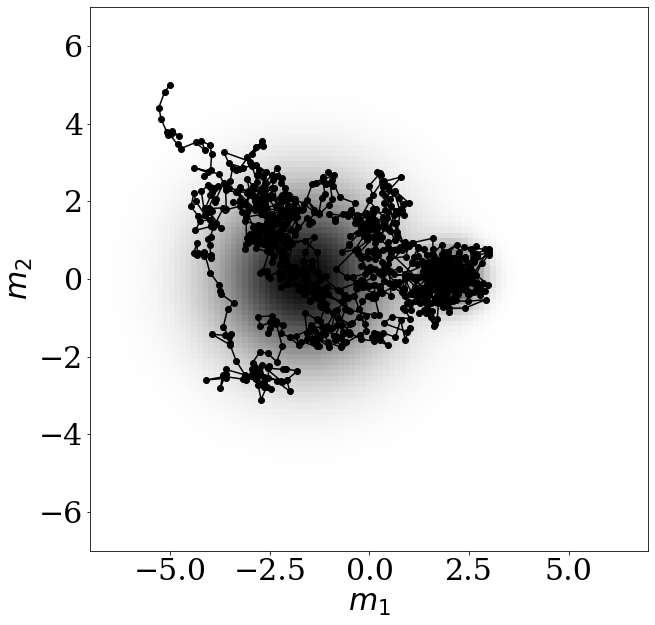

In [64]:
# Acceptance ratio.
print('acceptance ratio: %f ' % (accept/N))

# Trace plots.
plt.figure(figsize=(10,10))
plt.plot(sy,'k',linewidth=2)
plt.xlim([0,N])
plt.grid()
plt.xlabel('samples')
plt.savefig('trace.pdf')
plt.show()

# Auto-correlation.
cc=np.correlate(sy,sy,'full')/np.sum(sx*sx)
cc=cc[N-1:]

# Estimate of the effective sample size (Gelman et al., 2013).
Neff=0.0
for i in range(N-1):
    if (cc[i]+cc[i+1]>0.0):
        Neff+=cc[i]
        
Neff=N/(1.0+2.0*Neff)
print('effective sample size: %f' % Neff)

# Plot autocorrelation function.
plt.figure(figsize=(10,10))
plt.plot(cc[0:N_plot],'k',linewidth=2)
plt.xlabel('samples')
plt.xlim([0,N_plot])
plt.grid()
plt.savefig('autocorrelation.pdf')
plt.show()

# 1D marginals.
P=p(x,y)

px=0.1*np.sum(P,axis=0)
px=10.0*px/np.sum(px)

py=0.1*np.sum(P,axis=1)
py=10.0*py/np.sum(py)

plt.figure(figsize=(10,10))
n, bins, patches = plt.hist(sx, 30, density=True, facecolor='k', alpha=0.5)
plt.plot(np.linspace(-5.0,5.0,100),px,'k',linewidth=2)
plt.xlabel('x')
#plt.title('x marginal')
plt.xlim([-5.0,5.0])
plt.savefig('x_marginal.pdf')
plt.show()

plt.figure(figsize=(10,10))
n, bins, patches = plt.hist(sy, 30, density=True, facecolor='k', alpha=0.5)
plt.plot(np.linspace(-5.0,5.0,100),py,'k',linewidth=2)
plt.xlabel('y')
#plt.title('y marginal')
plt.xlim([-5.0,5.0])
plt.savefig('y_marginal.pdf')
plt.show()

# Plot samples.
if True:
    plt.figure(figsize=(10,10))
    plt.pcolor(x,y,p(x,y),cmap='binary')
    #plt.colorbar()
    plt.xlabel(r'$m_1$')
    plt.ylabel(r'$m_2$')
    plt.plot(sx[0:N_plot],sy[0:N_plot],'k')
    plt.plot(sx[0:N_plot],sy[0:N_plot],'ko')
    plt.xlim([-7.0,7.0])
    plt.ylim([-7.0,7.0])
    plt.savefig('trajectories.pdf')
    #plt.title('trajectory')
    plt.show()

